In [21]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from IPython.display import clear_output
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim





In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
#define value
batch_size = 256
num_epochs = 2000

In [24]:
PATH = 'C:/Users/DELL/Downloads/SimpsonsData/'

In [25]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor()          
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

In [26]:
dataset = ImageFolder(root=PATH, transform=transform)

In [27]:
data = []
for i in range(len(dataset)):
    temp = dataset[i][0]
    np.array(temp)
    data.append(temp)

In [28]:
data = torch.stack(data)

In [29]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [30]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: 3 x 64 x 64
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 64 x 32 x 32

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 128 x 16 x 16

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 256 x 8 x 8

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01, inplace=True),
            # output: 512 x 4 x 4

            nn.Flatten(),
            #output : 512*4*4
            nn.Linear(in_features=512*4*4,out_features=256),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Linear(in_features=256,out_features=1),
            
            nn.Sigmoid()
            # output: 1 x 1 x 1
        )

        

    def forward(self, x):
        return self.main(x)


In [31]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=512, out_features= 1024, bias=True),
            nn.Tanh(),
            nn.Unflatten(1, (1024, 1, 1)),  

            # output : 1024 x 1 x 1
            nn.ConvTranspose2d(in_channels=1024, out_channels=768, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            # output : 768 x 2 x 2
            
            nn.ConvTranspose2d(in_channels=768, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.1),
            #output : 512 x 4 x 4

            nn.ConvTranspose2d(in_channels=512, out_channels=384, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.05),
            # output: 128 x 8 x 8
            
            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.02),
            # output : 256 x 16 x 16

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.01),
            # output : 128 x 32 x 32

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
            # output: 3 x 64 x 64            
        )

    def forward(self, x):
        return self.main(x)


torch.Size([1, 3, 64, 64])
Min value: 0.4997026324272156 Max value: 0.5002791881561279
(3, 64, 64)


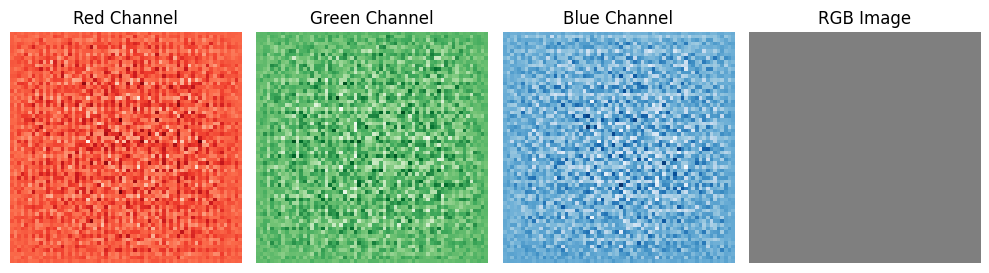

In [32]:
#test generator
random_tensor = torch.randn(1,512)
generator_test = Generator()
result = generator_test(random_tensor)

print(result.shape)
print("Min value:", result.min().item(), "Max value:", result.max().item())

# Tách các kênh màu
red_channel = result.detach().numpy()[0, 0, :, :]  
green_channel = result.detach().numpy()[0, 1, :, :] 
blue_channel = result.detach().numpy()[0, 2, :, :] 

plt.figure(figsize=(10, 4))

# Red channel
plt.subplot(1, 4, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(1, 4, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(1, 4, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')
print(result[0].detach().numpy().shape)
# Stacked RGB image
plt.subplot(1, 4, 4)
plt.imshow(result[0].permute(1,2,0).detach().numpy())
plt.title('RGB Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [33]:
def make_image(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
  noise= torch.randn(examples, 512).to(device)
  generated_images = generator(noise)
  #generated_images = generated_images.reshape(examples,3,128,128)
  plt.figure(figsize=figsize)
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


  for i in range(generated_images.shape[0]):
    # Tách các kênh màu
    red_channel = generated_images.cpu().detach().numpy()[i, 0, :, :]
    green_channel = generated_images.cpu().detach().numpy()[i, 1, :, :]
    blue_channel = generated_images.cpu().detach().numpy()[i, 2, :, :]
    # Ghép các kênh màu lại thành một ảnh RGB
    stacked_image = np.stack((red_channel, green_channel, blue_channel), axis = -1)
    plt.subplot(5, 5, i + 1)
    plt.imshow(stacked_image,interpolation='nearest',cmap='gray_r')
    plt.axis('off')

  

  plt.tight_layout()
  path = 'E:\GAN_result'
  plt.savefig(os.path.join(path,'gan_generated_image %d.png' %epoch))
  plt.close('all')
  # plt.show()

In [34]:
#init the sub-network for GAN

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=8192, out_features=256, bias=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Linear(in_features=256, out_features=1, bias=True)
    (12): Sigmoid()
  )
)

In [35]:
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Generator_optimizer, mode='min', factor=0.5, patience=5)
# D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Discriminator_optimizer, mode='min', factor=0.5, patience=5)


***Train 1***

Loss_D: 1.3082 Loss_G: 0.7077 D(x): 0.5211 D(G(z)): 0.5154 / 0.5117
Epoch  3
Epoch :  [3/2000] 


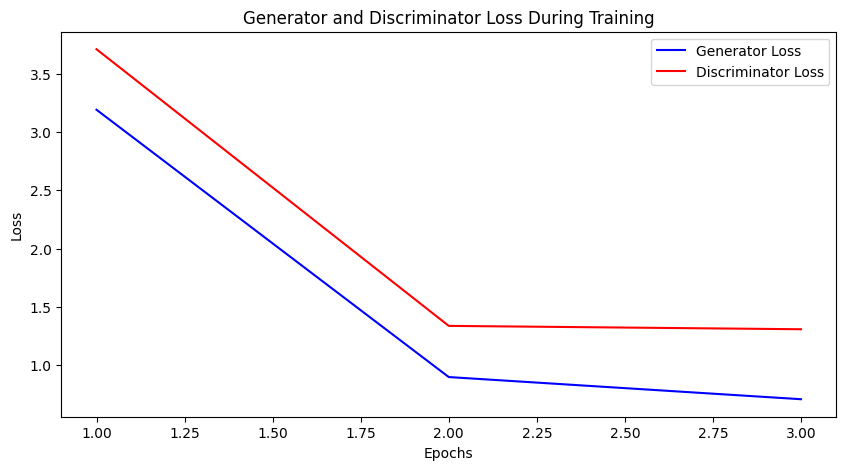

 66%|██████▌   | 25/38 [00:07<00:03,  3.46it/s]


KeyboardInterrupt: 

In [41]:
g_history = []
d_history = []
real_label = 1.
fake_label = 0.
for epoch in range(num_epochs):
    batch_count = int(data.shape[0]/batch_size)
    print("Epoch ",epoch)
    shuffle_factor = torch.randperm(data.size(0))
    data = data[shuffle_factor]

    avg_loss_d = 0 
    avg_loss_g = 0
    print('Epoch : ',f'[{epoch}/{num_epochs}] ')
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(g_history) + 1), g_history, 'b', label='Generator Loss')
    plt.plot(range(1, len(g_history) + 1), d_history, 'r', label='Discriminator Loss')
    plt.title('Generator and Discriminator Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    for i in tqdm(range(batch_count)):
        real_data = data[i*batch_size:(i+1)*batch_size].to(device)

        # Cập nhật Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ## Đào tạo với dữ liệu thật


        discriminator.zero_grad()
        # real_data = data[0].to(device)
        batch_size = real_data.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_data).view(-1)
        loss_d_real = criterion(output, labels)
        loss_d_real.backward()
        D_x = output.mean().item()

        ## Đào tạo với dữ liệu giả
        noise = torch.randn(batch_size, 512, device=device)
        fake_data = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake_data.detach()).view(-1)
        loss_d_fake = criterion(output, labels)
        loss_d_fake.backward()
        D_G_z1 = output.mean().item()
        loss_d = loss_d_real + loss_d_fake
        avg_loss_d += loss_d       
        optimizer_d.step()

        # Cập nhật Generator: maximize log(D(G(z)))
        generator.zero_grad()
        labels.fill_(real_label)
        output = discriminator(fake_data).view(-1)
        loss_g = criterion(output, labels)
        avg_loss_g += loss_g
        loss_g.backward()
        D_G_z2 = output.mean().item()
        optimizer_g.step()
    
    avg_loss_d /= len(dataloader)
    avg_loss_g /= len(dataloader)

    d_history.append(avg_loss_d.detach().cpu().numpy())
    g_history.append(avg_loss_g.detach().cpu().numpy())

    clear_output()
    print(  f'Loss_D: {avg_loss_d.item():.4f} Loss_G: {avg_loss_g.item():.4f} '
            f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    if epoch % 5 == 0 :
        make_image(epoch,generator)

        
        

***Train 2***

In [37]:
data.shape[0]

9877

In [40]:
#train model
for epoch in range(num_epochs):
  batch_count = int(data.shape[0]/batch_size)
  print("Epoch ",epoch)
  shuffle_factor = torch.randperm(data.size(0))
  data = data[shuffle_factor]
  for i in tqdm(range(batch_count)):
    data_train = data[i*batch_size:(i+1)*batch_size].to(device)
    
    #discriminator training
    discriminator.zero_grad()
    real_label = torch.ones(batch_size,1).to(device)
    output = discriminator(data_train)
    D_loss_real = criterion(output, real_label)
    D_loss_real.backward()

    #train D with fake data 
    noise = torch.randn(batch_size, 512).to(device)
    fake_data = generator(noise).to(device)
    fake_label = torch.zeros(batch_size,1).to(device)
    output = discriminator(fake_data.detach())
    D_loss_fake = criterion(output, fake_label)
    D_loss_fake.backward()
    
    optimizer_d.step()

    #generator.zero_grad()
    generator.zero_grad()
    output = discriminator(fake_data)
    G_loss = criterion(output, fake_label)
    G_loss.backward()

    optimizer_g.step()
    #print(f'End of batch {i} : 'f'Loss_D: {D_loss_real.item() + D_loss_fake.item()}, Loss_G: {G_loss.item()}' )
    # i += batch_size
  if epoch == 0 or epoch % 50 == 0 :
     make_image(epoch, generator)


Epoch  0


100%|██████████| 38/38 [00:09<00:00,  3.86it/s]


Epoch  1


100%|██████████| 38/38 [00:09<00:00,  3.94it/s]


Epoch  2


100%|██████████| 38/38 [00:08<00:00,  4.28it/s]


Epoch  3


100%|██████████| 38/38 [00:09<00:00,  4.19it/s]


Epoch  4


100%|██████████| 38/38 [00:09<00:00,  4.12it/s]


Epoch  5


100%|██████████| 38/38 [00:09<00:00,  4.06it/s]


Epoch  6


100%|██████████| 38/38 [00:09<00:00,  4.01it/s]


Epoch  7


100%|██████████| 38/38 [00:09<00:00,  3.98it/s]


Epoch  8


100%|██████████| 38/38 [00:09<00:00,  3.96it/s]


Epoch  9


100%|██████████| 38/38 [00:09<00:00,  3.93it/s]


Epoch  10


100%|██████████| 38/38 [00:09<00:00,  3.88it/s]


Epoch  11


100%|██████████| 38/38 [00:09<00:00,  3.88it/s]


Epoch  12


100%|██████████| 38/38 [00:09<00:00,  3.86it/s]


Epoch  13


100%|██████████| 38/38 [00:09<00:00,  3.85it/s]


Epoch  14


100%|██████████| 38/38 [00:09<00:00,  3.86it/s]


Epoch  15


100%|██████████| 38/38 [00:09<00:00,  3.84it/s]


Epoch  16


100%|██████████| 38/38 [00:09<00:00,  3.86it/s]


Epoch  17


100%|██████████| 38/38 [00:09<00:00,  3.83it/s]


Epoch  18


100%|██████████| 38/38 [00:09<00:00,  3.85it/s]


Epoch  19


100%|██████████| 38/38 [00:09<00:00,  3.83it/s]


Epoch  20


100%|██████████| 38/38 [00:09<00:00,  3.83it/s]


Epoch  21


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  22


100%|██████████| 38/38 [00:09<00:00,  3.82it/s]


Epoch  23


100%|██████████| 38/38 [00:09<00:00,  3.83it/s]


Epoch  24


100%|██████████| 38/38 [00:09<00:00,  3.84it/s]


Epoch  25


100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


Epoch  26


100%|██████████| 38/38 [00:09<00:00,  3.80it/s]


Epoch  27


100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


Epoch  28


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  29


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  30


100%|██████████| 38/38 [00:09<00:00,  3.82it/s]


Epoch  31


100%|██████████| 38/38 [00:09<00:00,  3.80it/s]


Epoch  32


100%|██████████| 38/38 [00:10<00:00,  3.80it/s]


Epoch  33


100%|██████████| 38/38 [00:09<00:00,  3.80it/s]


Epoch  34


100%|██████████| 38/38 [00:09<00:00,  3.82it/s]


Epoch  35


100%|██████████| 38/38 [00:10<00:00,  3.80it/s]


Epoch  36


100%|██████████| 38/38 [00:09<00:00,  3.82it/s]


Epoch  37


100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


Epoch  38


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  39


100%|██████████| 38/38 [00:10<00:00,  3.79it/s]


Epoch  40


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  41


100%|██████████| 38/38 [00:09<00:00,  3.86it/s]


Epoch  42


100%|██████████| 38/38 [00:09<00:00,  3.88it/s]


Epoch  43


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  44


100%|██████████| 38/38 [00:09<00:00,  3.82it/s]


Epoch  45


100%|██████████| 38/38 [00:09<00:00,  3.81it/s]


Epoch  46


100%|██████████| 38/38 [00:10<00:00,  3.74it/s]


Epoch  47


100%|██████████| 38/38 [00:10<00:00,  3.71it/s]


Epoch  48


100%|██████████| 38/38 [00:10<00:00,  3.72it/s]


Epoch  49


100%|██████████| 38/38 [00:10<00:00,  3.73it/s]


Epoch  50


100%|██████████| 38/38 [00:10<00:00,  3.75it/s]


Epoch  51


100%|██████████| 38/38 [00:10<00:00,  3.62it/s]


Epoch  52


 61%|██████    | 23/38 [00:06<00:04,  3.68it/s]


KeyboardInterrupt: 